**response_format** method was used in this notebook.

In [2]:
! pip install -q openai pydantic

In [3]:
from enum import Enum
import json
import requests
from openai import OpenAI
from pydantic import BaseModel, Field

In [4]:
from google.colab import userdata

openai_api_key = userdata.get('OPENAI_API_KEY')

In [5]:
client = OpenAI(api_key=openai_api_key)
MODEL = "gpt-4o-2024-08-06"

##### Json Schema

In [7]:
response = client.chat.completions.create(
  model = MODEL,
  messages = [
    {
      "role": "system",
      "content": "You are a helpful math tutor."
    },
    {
      "role": "user",
      "content": "solve 8x + 31 = 2"
    }
  ],
  response_format = {
    "type": "json_schema",
    "json_schema": {
      "name": "math_response",
      "strict": True,
      "schema": {
        "type": "object",
        "properties": {
          "steps": {
            "type": "array",
            "items": {
              "type": "object",
              "properties": {
                "explanation": {
                  "type": "string"
                },
                "output": {
                  "type": "string"
                }
              },
              "required": ["explanation", "output"],
              "additionalProperties": False
            }
          },
          "final_answer": {
            "type": "string"
          }
        },
        "required": ["steps", "final_answer"],
        "additionalProperties": False
      }
    }
  }
)

print(response.choices[0].message.content)

{"steps":[{"explanation":"Start with the equation 8x + 31 = 2. The goal is to solve for x.","output":"8x + 31 = 2"},{"explanation":"Subtract 31 from both sides to isolate the term with x on one side of the equation.","output":"8x = 2 - 31"},{"explanation":"Calculate the right side of the equation: 2 - 31 = -29.","output":"8x = -29"},{"explanation":"Divide both sides of the equation by 8 to solve for x.","output":"x = -29/8"}],"final_answer":"x = -\\frac{29}{8}"}


In [14]:
answer =  response.choices[0].message.content
parsed_answer = json.loads(answer)
steps = parsed_answer['steps']
final_answer = parsed_answer['final_answer']

In [16]:
final_answer

'x = -\\frac{29}{8}'

In [13]:
for step in steps:
    print(f"Explanation: {step['explanation']}")
    print(f"Output: {step['output']}")
    print()


Explanation: Start with the equation 8x + 31 = 2. The goal is to solve for x.
Output: 8x + 31 = 2

Explanation: Subtract 31 from both sides to isolate the term with x on one side of the equation.
Output: 8x = 2 - 31

Explanation: Calculate the right side of the equation: 2 - 31 = -29.
Output: 8x = -29

Explanation: Divide both sides of the equation by 8 to solve for x.
Output: x = -29/8



##### Pydantic

In [17]:
query = "solve 8x + 31 = 2"

In [18]:
system_prompt = "You are a helpful math tutor."

In [19]:
class MathTutor(BaseModel):
    class Step(BaseModel):
        explanation: str = Field(description="Description of the step taken.")
        output: str = Field(description="Only answer of each step without text")

    steps: list[Step]
    final_answer: str = Field(
        description="The final answer of the equation."
    )


def math_response(query: str):
    completion = client.beta.chat.completions.parse(
        model=MODEL,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": query},
        ],
        response_format=MathTutor,
    )

    return completion.choices[0].message.parsed


response_pydantic = math_response(query)
response_pydantic.model_dump()

{'steps': [{'explanation': 'Subtract 31 from both sides of the equation to isolate the term with x on the left side.',
   'output': '8x = -29'},
  {'explanation': 'Divide both sides of the equation by 8 to solve for x.',
   'output': 'x = -29/8'}],
 'final_answer': 'x = -29/8'}

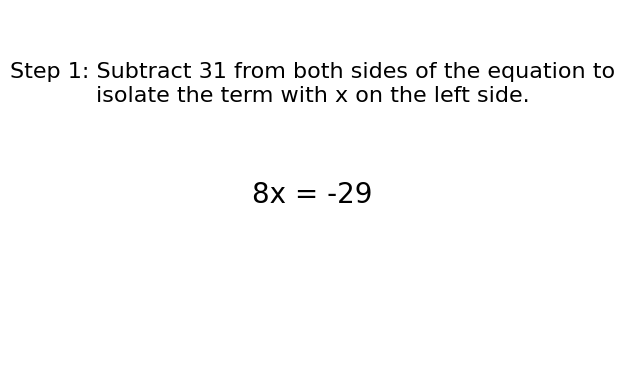

In [26]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

steps = response_pydantic.model_dump()['steps']

fig, ax = plt.subplots()
ax.axis('off')

# Add text placeholders
title = ax.text(0.5, 0.8, '', fontsize=16, ha='center', va='center', wrap=True)
step_output = ax.text(0.5, 0.5, '', fontsize=20, ha='center', va='center', wrap=True)

# Update function for the animation
def update(frame):
    step = steps[frame]
    title.set_text(f"Step {frame + 1}: {step['explanation']}")
    step_output.set_text(f"{step['output']}")

# Create the animation
ani = FuncAnimation(fig, update, frames=len(steps), interval=2000, repeat=False)

ani.save('steps_animation.gif', writer='imagemagick', fps=1)